# Imports

In [1]:

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import numpy as np
import pickle

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Input

from architectures.protoshotxai import ProtoShotXAI

# Get Base Model to be Explained (e.g., ResNet50)

In [2]:
base_model = ResNet50(weights="imagenet", include_top=True,input_tensor=Input(shape=(224, 224, 3)))
protoshot = ProtoShotXAI(base_model)

# Load query sample and support data

In [3]:
french_bulldog_and_tank = pickle.load(open('../data/french_bulldog_and_tank.pickle','rb'))
query = preprocess_input(french_bulldog_and_tank['french_bulldog_and_tank'])
query = np.expand_dims(np.copy(query),axis=0)
miniImageNet_train_data = np.load('../data/miniImageNet_train_data.npy')

# Use 100 samples from the support sample of a tank class and run pixel perturbations for feature attribution

In [4]:
#In ImageNet the french bull dog is class index 245, tank is class index 847
#Using the miniImageNet subset to save space the indicies are 14 and 49, respectively
support_data = preprocess_input(miniImageNet_train_data[49][:100]) #Tank 847
class_indx = 847
ref_pixel = [-0.939, -1.779, -0.68] #Average Background pixel after preprocessing
score_matrix = protoshot.image_feature_attribution(support_data,query,class_indx, ref_pixel)

100%|██████████| 224/224 [02:32<00:00,  1.47it/s]


# Display feature attributions of tank

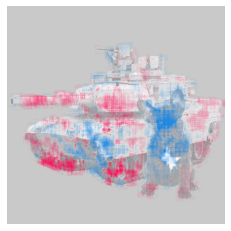

In [5]:
import matplotlib.pyplot as plt
import utils.shap_color_scheme.colors as colors
from skimage.color import rgb2gray


abs_vals = np.abs(score_matrix).flatten()
max_val = np.nanpercentile(abs_vals, 99.9)
fig = plt.figure(frameon=False)
im1 = plt.imshow(rgb2gray(query[0]), interpolation = 'nearest', cmap='gray', alpha=0.4)
im2 = plt.imshow(score_matrix, cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
plt.axis('off')
plt.savefig("ProtoShotXAI_Tank_Features_ResNet50.png",dpi=450)

# Use 100 samples from the support sample of a french bulldog class and run pixel perturbations for feature attribution

In [6]:
#In ImageNet the french bull dog is class index 245, tank is class index 847
#Using the miniImageNet subset to save space the indicies are 14 and 49, respectively
support_data = preprocess_input(miniImageNet_train_data[14][:100]) #Tank 847
class_indx = 245
ref_pixel = [-0.939, -1.779, -0.68] #Average Background pixel after preprocessing
score_matrix = protoshot.image_feature_attribution(support_data,query,class_indx, ref_pixel)

100%|██████████| 224/224 [02:32<00:00,  1.47it/s]


# Display feature attributions of french bulldog

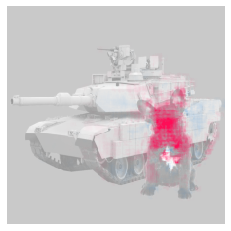

In [8]:
import matplotlib.pyplot as plt
import utils.shap_color_scheme.colors as colors
from skimage.color import rgb2gray


abs_vals = np.abs(score_matrix).flatten()
max_val = np.nanpercentile(abs_vals, 99.9)
fig = plt.figure(frameon=False)
im1 = plt.imshow(rgb2gray(query[0]), interpolation = 'nearest', cmap='gray', alpha=0.4)
im2 = plt.imshow(score_matrix, cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
plt.axis('off')
plt.savefig("ProtoShotXAI_French_Bulldog_Features_ResNet50.png",dpi=450)
